# Automatic Speech Recognition with Speaker Diarization

In [ ]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode

# ## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

## Install TorchAudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html

You should consider upgrading via the '/home/taejinp/.conda/envs/env04/bin/python -m pip install --upgrade pip' command.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
sox is already the newest version (14.4.2+git20190427-2).
ffmpeg is already the newest version (7:4.2.4-1ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libfprint-2-tod1 libllvm10
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libsndfile1-dev
The following packages will be upgraded:
  libsndfile1 libsndfile1-dev
2 upgraded, 0 newly installed, 0 to remove and 177 not upgraded.
Need to get 450 kB of archives.
After this operation, 6,144 B of additional disk space will be used.
Do you want to continue? [Y/n] ^C
You should consider upgrading via the '/home/taejinp/.conda/envs/env04/bin/python -m pip install --upgrade pip' command.


# Introduction

Speaker diarization lets us figure out "who spoke when" in the transcription. Without speaker diarization, we cannot distinguish the speakers in the transcript generated from automatic speech recognition (ASR). Nowadays, ASR combined with speaker diarization has shown immense use in many tasks, ranging from analyzing meeting transcription to media indexing. 

In this tutorial, we demonstrate how we can get ASR transcriptions combined with speaker labels. Since we don't include detailed process of getting ASR result or diarization result, please refer to the following links for more in-depth description.

If you need detailed understanding of transcribing words with ASR, refer to this [ASR Tutorial](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/asr/ASR_with_NeMo.ipynb) tutorial.


For detailed parameter setting and execution of speaker diarization, refer to this [Diarization Inference](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/speaker_tasks/Speaker_Diarization_Inference.ipynb) tutorial.


An example script that runs ASR and speaker diarization together can be found at [ASR with Diarization](https://github.com/NVIDIA/NeMo/blob/main/examples/speaker_tasks/diarization/asr_with_diarization.py).

### Speaker diarization in ASR pipeline

Speaker diarization result in ASR pipeline should align well with ASR output. Thus, we use ASR output to create Voice Activity Detection (VAD) timestamps to obtain segments we want to diarize. The segments we obtain from the VAD timestamps are further segmented into sub-segments in the speaker diarization step. Finally, after obtaining the speaker labels from speaker diarization, we match the decoded words with speaker labels to generate a transcript with speaker labels.

    ASR → VAD timestamps and decoded words → speaker diarization → speaker label matching

### Import libraries

Let's first import nemo asr and other libraries for visualization purposes.

In [1]:
import nemo.collections.asr as nemo_asr
import numpy as np
from IPython.display import Audio, display
import librosa
import os
import wget
import matplotlib.pyplot as plt

import nemo
from nemo.collections.asr.parts.utils.diarization_utils import ASR_DIAR_OFFLINE

import glob

import pprint
pp = pprint.PrettyPrinter(indent=4)

[NeMo W 2021-10-14 11:07:19 optimizers:47] Apex was not found. Using the lamb optimizer will error out.
[NeMo W 2021-10-14 11:07:20 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text_dali._AudioTextDALIDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [2]:
def read_file(path_to_file):
    with open(path_to_file) as f:
        contents = f.read().splitlines()
    return contents

We demonstrate this tutorial using a merged AN4 audioclip. The merged audioclip contains the speech of two speakers (male and female) reading dates in different formats. Run the following script to download the audioclip and play it.

In [3]:
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data')
os.makedirs(data_dir, exist_ok=True)
an4_audio_url = "https://nemo-public.s3.us-east-2.amazonaws.com/an4_diarize_test.wav"
if not os.path.exists(os.path.join(data_dir,'an4_diarize_test.wav')):
    AUDIO_FILENAME = wget.download(an4_audio_url, data_dir)
else:
    AUDIO_FILENAME = os.path.join(data_dir,'an4_diarize_test.wav')

audio_file_list = glob.glob(f"{data_dir}/*.wav")
print("Input audio file list: \n", audio_file_list)

signal, sample_rate = librosa.load(AUDIO_FILENAME, sr=None)
display(Audio(signal,rate=sample_rate))

Input audio file list: 
 ['/home/taejinp/projects/asr_with_diar/NeMo/tutorials/speaker_tasks/data/an4_diarize_test.wav']


`display_waveform()` and `get_color()` functions are defined for displaying the waveform with diarization results.

In [4]:
def display_waveform(signal,text='Audio',overlay_color=[]):
    fig,ax = plt.subplots(1,1)
    fig.set_figwidth(20)
    fig.set_figheight(2)
    plt.scatter(np.arange(len(signal)),signal,s=1,marker='o',c='k')
    if len(overlay_color):
        plt.scatter(np.arange(len(signal)),signal,s=1,marker='o',c=overlay_color)
    fig.suptitle(text, fontsize=16)
    plt.xlabel('time (secs)', fontsize=18)
    plt.ylabel('signal strength', fontsize=14);
    plt.axis([0,len(signal),-0.5,+0.5])
    time_axis,_ = plt.xticks();
    plt.xticks(time_axis[:-1],time_axis[:-1]/sample_rate);
    
COLORS="b g c m y".split()

def get_color(signal,speech_labels,sample_rate=16000):
    c=np.array(['k']*len(signal))
    for time_stamp in speech_labels:
        start,end,label=time_stamp.split()
        start,end = int(float(start)*16000),int(float(end)*16000),
        if label == "speech":
            code = 'red'
        else:
            code = COLORS[int(label.split('_')[-1])]
        c[start:end]=code
    
    return c 

Using the above function, we can display the waveform of the example audio clip. 

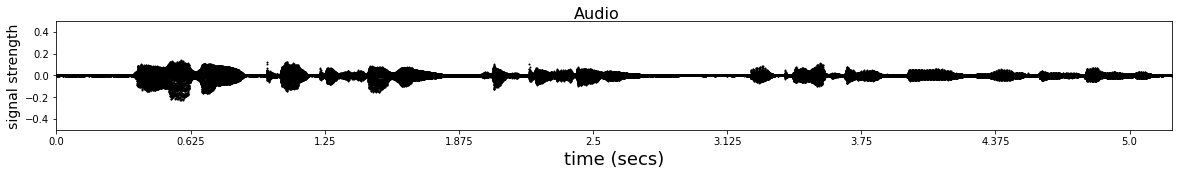

In [5]:
display_waveform(signal)

### Parameter setting for ASR and diarization
First, we need to setup the following parameters for ASR and diarization. We start our demonstration by first transcribing the audio recording using our pretrained ASR model `QuartzNet15x5Base-En` and use the CTC output probabilities to get timestamps for the spoken words. We then use these timestamps to get speaker label information using speaker diarizer model. 

In [6]:
CONFIG_URL = "https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/speaker_diarization.yaml"

params = {
    "round_float": 2,
    "window_length_in_sec": 1.0,
    "shift_length_in_sec": 0.25,
    "fix_word_ts_with_VAD": False,
    "print_transcript": False,
    "word_gap_in_sec": 0.01,
    "max_word_ts_length_in_sec": 0.6,
    "minimum": True,
    "threshold": 300, 
    "diar_config_url": CONFIG_URL,
    "ASR_model_name": 'QuartzNet15x5Base-En',
}


Let's create an instance from ASR_DIAR_OFFLINE class. We pass the ``params`` variable to setup the parameters for both ASR and diarization. 

In [7]:
asr_diar_offline = ASR_DIAR_OFFLINE(params)
asr_model = asr_diar_offline.set_asr_model(params['ASR_model_name'])

[NeMo I 2021-10-14 11:07:27 cloud:56] Found existing object /home/taejinp/.cache/torch/NeMo/NeMo_1.3.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2021-10-14 11:07:27 cloud:62] Re-using file from: /home/taejinp/.cache/torch/NeMo/NeMo_1.3.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2021-10-14 11:07:27 common:694] Instantiating model from pre-trained checkpoint


[NeMo W 2021-10-14 11:07:28 nemo_logging:349] /home/taejinp/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: 
        Found GPU%d %s which is of cuda capability %d.%d.
        PyTorch no longer supports this GPU because it is too old.
        The minimum cuda capability supported by this library is %d.%d.
        
      warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))
    


[NeMo I 2021-10-14 11:07:28 features:262] PADDING: 16
[NeMo I 2021-10-14 11:07:28 features:279] STFT using torch
[NeMo I 2021-10-14 11:07:31 save_restore_connector:143] Model EncDecCTCModel was successfully restored from /home/taejinp/.cache/torch/NeMo/NeMo_1.3.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


We will create folders that we need for storing VAD stamps and ASR/diarization results.

Under the folder named ``asr_with_diar``, the following folders will be created.

- ``oracle_vad``
- ``json_result``
- ``transcript_with_speaker_labels``


In [8]:
asr_diar_offline.create_directories()

print("Folders are created as below.")
print("VAD file path: \n", asr_diar_offline.oracle_vad_dir)
print("JSON result path: \n", asr_diar_offline.json_result_dir)
print("Transcript result path: \n", asr_diar_offline.trans_with_spks_dir)

Folders are created as below.
VAD file path: 
 /home/taejinp/projects/asr_with_diar/NeMo/tutorials/speaker_tasks/asr_with_diar/oracle_vad
JSON result path: 
 /home/taejinp/projects/asr_with_diar/NeMo/tutorials/speaker_tasks/asr_with_diar/json_result
Transcript result path: 
 /home/taejinp/projects/asr_with_diar/NeMo/tutorials/speaker_tasks/asr_with_diar/transcript_with_speaker_labels


### Run ASR and get word timestamps
Before we run speaker diarization, we should run ASR and get the ASR output to generate decoded words and timestamps for those words. The following two variables are obtained from `run_ASR()` function.

- words List[str]: contains the sequence of words.
- word_ts List[int]: contains frame level index of the start and the end of each word.

In [9]:
word_list, word_ts_list = asr_diar_offline.run_ASR(audio_file_list, asr_model)

print("Decoded word output: \n", word_list[0])
print("Word-level timestamps \n", word_ts_list[0])

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2021-10-14 11:07:31 patch_utils:49] torch.stft() signature has been updated for PyTorch 1.7+
    Please update PyTorch to remain compatible with later versions of NeMo.
[NeMo W 2021-10-14 11:07:31 nemo_logging:349] /home/taejinp/.local/lib/python3.8/site-packages/torch/_tensor.py:557: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
    To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
      return torch.floor_divide(self, other)
    


Decoded word output: 
 ['eleven', 'twenty', 'seven', 'fifty', 'seven', 'october', 'twenty', 'fourth', 'nineteen', 'seventy']
Word-level timestamps 
 [[0.42, 0.86], [1.0, 1.36], [1.4, 1.92], [2.0, 2.34], [2.38, 3.1], [3.2, 3.6], [3.64, 3.9], [3.94, 4.18], [4.32, 4.66], [4.68, 5.04]]


### Run diarization with extracted word timestamps


We need to convert ASR based VAD output (*.rttm format) to VAD manifest (*.json format) file. The following function converts the rttm files into manifest file and returns the path for manifest file.

Now that all the components for diarization is ready, let's run diarization by calling `run_diarization()` function.

In [10]:
oracle_manifest = 'asr_based_vad'
# If we know the number of speakers, we can assign "2".
num_speakers = None
speaker_embedding_model = 'ecapa_tdnn'

diar_labels = asr_diar_offline.run_diarization(audio_file_list, 
                                               word_ts_list, 
                                               oracle_manifest=oracle_manifest, 
                                               oracle_num_speakers=num_speakers,
                                               pretrained_speaker_model=speaker_embedding_model)

[NeMo W 2021-10-14 11:07:32 clustering_diarizer:123] requested ecapa_tdnn model name not available in pretrained models, instead


[NeMo I 2021-10-14 11:07:32 clustering_diarizer:127] Loading pretrained speakerdiarization_speakernet model from NGC
[NeMo I 2021-10-14 11:07:32 cloud:56] Found existing object /home/taejinp/.cache/torch/NeMo/NeMo_1.3.0/speakerdiarization_speakernet/eba9223fbafd1a0fb48ae8c38c448c90/speakerdiarization_speakernet.nemo.
[NeMo I 2021-10-14 11:07:32 cloud:62] Re-using file from: /home/taejinp/.cache/torch/NeMo/NeMo_1.3.0/speakerdiarization_speakernet/eba9223fbafd1a0fb48ae8c38c448c90/speakerdiarization_speakernet.nemo
[NeMo I 2021-10-14 11:07:32 common:694] Instantiating model from pre-trained checkpoint


[NeMo W 2021-10-14 11:07:32 modelPT:130] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_vad_energy/vox1vox2_fisher_swbd_train_manifest.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    num_workers: 15
    pin_memory: true
    
[NeMo W 2021-10-14 11:07:32 modelPT:137] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /manifests/combined_vad_energy/vox1vox2_fisher_swbd_dev_manifest.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: false
    time_length: 3
    num_workers: 15
    pin_memory: true
    


[NeMo I 2021-10-14 11:07:32 features:262] PADDING: 16
[NeMo I 2021-10-14 11:07:32 features:279] STFT using torch
[NeMo I 2021-10-14 11:07:32 label_models:90] Training with Angular Softmax Loss
[NeMo I 2021-10-14 11:07:32 save_restore_connector:143] Model ExtractSpeakerEmbeddingsModel was successfully restored from /home/taejinp/.cache/torch/NeMo/NeMo_1.3.0/speakerdiarization_speakernet/eba9223fbafd1a0fb48ae8c38c448c90/speakerdiarization_speakernet.nemo.
[NeMo I 2021-10-14 11:07:32 clustering_diarizer:259] Extracting embeddings for Diarization
[NeMo I 2021-10-14 11:07:32 audio_to_label:445] Time length considered for collate func is 1.0
[NeMo I 2021-10-14 11:07:32 audio_to_label:446] Shift length considered for collate func is 0.25
[NeMo I 2021-10-14 11:07:32 collections:266] Filtered duration for loading collection is 0.000000.
[NeMo I 2021-10-14 11:07:32 collections:270] # 16 files loaded accounting to # 1 labels
[NeMo I 2021-10-14 11:07:32 label_models:121] Setting up diarization par

100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

[NeMo I 2021-10-14 11:07:32 clustering_diarizer:292] Saved embedding files to /home/taejinp/projects/asr_with_diar/NeMo/tutorials/speaker_tasks/asr_with_diar/oracle_vad/speaker_outputs/embeddings
[NeMo I 2021-10-14 11:07:32 speaker_utils:194] Number of files to diarize: 1
[NeMo I 2021-10-14 11:07:32 speaker_utils:196] sample 'an4_diarize_test' embeddings shape is (256,)
    
[NeMo I 2021-10-14 11:07:32 speaker_utils:330] Performing Clustering



100%|██████████| 1/1 [00:00<00:00,  5.74it/s]
[NeMo W 2021-10-14 11:07:33 speaker_utils:344] Please check if each ground truth RTTMs was present in provided path2groundtruth_rttm_files
[NeMo W 2021-10-14 11:07:33 speaker_utils:345] Skipping calculation of Diariazation Error Rate


[NeMo I 2021-10-14 11:07:33 diarization_utils:692] Estimated n_spk [an4_diarize_test]: 2


`run_diarization()` function creates `./asr_with_diar/oracle_vad/pred_rttm/an4_diarize_test.rttm` file. Let's see what is written in this `rttm` file.

In [11]:
predicted_speaker_label_rttm_path = f"{ROOT}/asr_with_diar/oracle_vad/pred_rttms/an4_diarize_test.rttm"
pred_rttm = read_file(predicted_speaker_label_rttm_path)

pp.pprint(pred_rttm)

[   'SPEAKER an4_diarize_test 1   0.420   2.625 <NA> <NA> speaker_1 <NA> <NA>',
    'SPEAKER an4_diarize_test 1   3.045   1.995 <NA> <NA> speaker_0 <NA> <NA>']


`run_diarization()` also returns a variable named `diar_labels` which contains the estimated speaker label information with timestamps from the predicted rttm file.

Diarization Labels:
['0.42 3.045 speaker_1', '3.045 5.04 speaker_0']


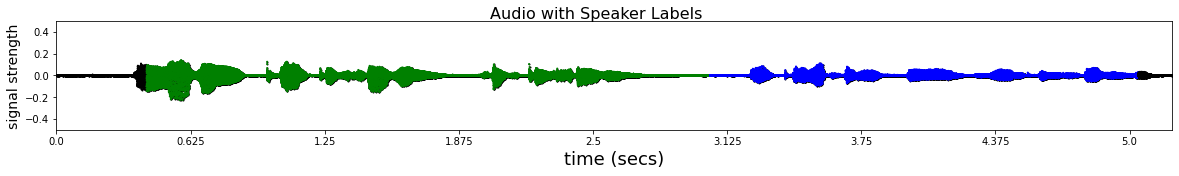

In [16]:
print("Diarization Labels:")
pp.pprint(diar_labels[0])

color = get_color(signal, diar_labels[0])
display_waveform(signal,'Audio with Speaker Labels', color)
display(Audio(signal,rate=16000))

### Check the transcription output
Now we've done all the processes for running ASR and diarization, let's match the diarization result with ASR result and get the final output. `write_json_and_transcript()` function matches diarization output `diar_labels` with `word_list` using the timestamp information `word_ts_list`. 

In [17]:
asr_output_dict = asr_diar_offline.write_json_and_transcript(audio_file_list, diar_labels, word_list, word_ts_list)

[NeMo I 2021-10-14 11:10:03 diarization_utils:845] VAD timestamps are not provided and skipping word timestamp fix. Please check VAD model.
[NeMo I 2021-10-14 11:10:03 diarization_utils:868] Creating results for Session: an4_diarize_test n_spk: 2 
[NeMo I 2021-10-14 11:10:03 diarization_utils:1022] Writing /home/taejinp/projects/asr_with_diar/NeMo/tutorials/speaker_tasks/asr_with_diar/json_result/an4_diarize_test.json
[NeMo I 2021-10-14 11:10:03 diarization_utils:1025] Writing /home/taejinp/projects/asr_with_diar/NeMo/tutorials/speaker_tasks/asr_with_diar/transcript_with_speaker_labels/an4_diarize_test.txt
[NeMo I 2021-10-14 11:10:03 diarization_utils:1028] Writing /home/taejinp/projects/asr_with_diar/NeMo/tutorials/speaker_tasks/asr_with_diar/audacity_label/an4_diarize_test.w.label


After running `write_json_and_transcript()` function, the transcription output will be located in `./asr_with_diar/transcript_with_speaker_labels` folder, which shows **start time to end time of the utterance, speaker ID, and words spoken** during the notified time.

In [18]:
transcription_path_to_file = f"{ROOT}/asr_with_diar/transcript_with_speaker_labels/an4_diarize_test.txt"
transcript = read_file(transcription_path_to_file)
pp.pprint(transcript)

[   '[00:00.42 - 00:03.04] speaker_1: eleven twenty seven fifty seven ',
    '[00:03.04 - 00:05.04] speaker_0: october twenty fourth nineteen']


Another output is transcription output in JSON format, which is saved in `./asr_with_diar/json_result`. 

In the JSON format output, we include information such as **transcription, estimated number of speakers (variable named `speaker_count`), start and end time of each word and most importantly, speaker label for each word.**

In [15]:
transcription_path_to_file = f"{ROOT}/asr_with_diar/json_result/an4_diarize_test.json"
json_contents = read_file(transcription_path_to_file)
pp.pprint(json_contents)

[   '{',
    '    "status": "Success",',
    '    "session_id": "an4_diarize_test",',
    '    "transcription": "eleven twenty seven fifty seven october twenty '
    'fourth nineteen seventy",',
    '    "speaker_count": 2,',
    '    "words": [',
    '        {',
    '            "word": "eleven",',
    '            "start_time": 0.42,',
    '            "end_time": 0.99,',
    '            "speaker_label": "speaker_1"',
    '        },',
    '        {',
    '            "word": "twenty",',
    '            "start_time": 1.0,',
    '            "end_time": 1.39,',
    '            "speaker_label": "speaker_1"',
    '        },',
    '        {',
    '            "word": "seven",',
    '            "start_time": 1.4,',
    '            "end_time": 1.99,',
    '            "speaker_label": "speaker_1"',
    '        },',
    '        {',
    '            "word": "fifty",',
    '            "start_time": 2.0,',
    '            "end_time": 2.37,',
    '            "speaker_label": "spea